# Silver Layer Creation

**Purpose:** Clean raw data from the [Bronze](./1_bronze.ipynb) layer to create a unified data asset. Here we engage in comprehensive cleaning, exploratory analysis, and imputation strategies. This process creates a clean dataset which is suitable for downstream analytics and modeling.

**Key Processes:**
- **Data Integration**: Combine and standardize data from multiple regional sources
- **Exploratory Analysis**: Visual analysis to understand data patterns and inform imputation strategies  
- **Planned Imputation**: Apply breed-specific probabilistic imputation for missing demographic data
- **Quality Assurance**: Validate completeness and consistency of final dataset
- **Materialization**: Create analysis-ready dataset for Gold

**Transformations Applied:**
- **Standardize** column names to lowercase snake_case
- **Harmonize** categorical values across data sources
- **Compute** age from intake dates and birth dates where available
- **Impute** missing ages using species-specific median values
- **Impute** missing sex and primary color using breed-based probability distributions

This data will be used when creating [Gold](./3_gold.ipynb), where tailored data assets will be created to efficiently answer research questions.

For more on Medallion Architecture, see [Databricks Glossary: Medallion Architecture](https://www.databricks.com/glossary/medallion-architecture) (Databricks, n.d.).

-----


## Table of Contents

1. [Setup](#1-setup)  
   Install required packages and import libraries.

2. [Configuration & Data Loading](#2-configuration-and-data-loading)  
   Centralize file paths, API parameters, and date-column lists, then ingest the raw Bronze dataset into pandas.

3. [Define Helper Functions](#3-define-helper-functions)  
   Define all cleaning and transforms as modular functions—date anomaly filters, age parsers, imputation routines, etc.

4. [Data Cleaning & Standardization](#4-data-cleaning--standardization)  
   Harmonize column names, drop duplicates, and enforce schema across sources.

5. [Value Mapping & Data Type Enforcement](#5-value-mapping--data-type-enforcement)  
   Apply categorical/value mappings and cast explicit dtypes for Silver.

6. [Execute Transformations](#6-execute-transformations)  
   Run each helper function in sequence to clean and enrich the DataFrame.

7. [Create Silver](#7-create-silver)  
   Combine cleaned DataFrames into unified working dataset with complete schema for analysis.

   7.1. [Visual Analysis to Inform Imputation Strategies](#71-visual-analysis-to-inform-imputation-strategies)  
   Use exploratory data analysis and visualizations to understand underlying data patterns and develop imputation approaches.

   7.1.1. [Age](#711-age)

   7.1.2. [Sex and Primary Color](#712-sex-and-primary-color)

   7.1.3. [Primary Color](#713-primary-color)

8. [Implement Imputation Strategies](#8-implement-imputation-strategies)

   8.1. [Compute Age from Intake and DOB](#81-compute-age-from-intake-and-dob)

   8.2. [Apply Species-Specific Median Imputations for Missing Ages](#82-apply-species-specific-median-imputations-for-missing-ages)

   8.3. [Sex Standardization and Breed-Based Imputation](#83-sex-standardization-and-breed-based-imputation)

   8.4. [Apply Primary Color Imputation](#84-apply-primary-color-imputation)

   8.5. [Imputation Completion Summary](#85-imputation-completion-summary)

9. [Materialize Final Silver Dataset](#9-materialize-final-silver-dataset)  
   Here we apply the final schema, and create analysis-ready dataset.

10. [Data Quality Assessment](#10-data-quality-assessment)  
    Validate completeness, consistency, and distribution patterns of the final silver dataset.

11. [References](#11-references)

-----

## 1. Setup

**Purpose:**  Ensure the environment has all necessary libraries installed and imported.  
```python
# Install project-wide dependencies
%pip install -r ../../requirements.txt
``` 

> **Note:** we use a project-wide `requirements.txt` for consistency

In [427]:
%pip install -r ../../requirements.txt

4086.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [428]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

-----

## 2. Configuration and Data Loading

**Purpose:** Here we centralize file paths, API endpoints, and date-column definitions, then ingest every raw Bronze source.

In [429]:
# Data source configurations
BRONZE_DIR = "../../data-assets/bronze"
BRONZE_FILE_NAME = "{}_df.parquet"

# Load all the Bronze datasets
BRONZE_FILES = ["dallas", "san_jose", "soco"]
BRONZE_FILE_PATHS = {
    file: os.path.join(BRONZE_DIR, BRONZE_FILE_NAME.format(file))
    for file in BRONZE_FILES
}
BRONZE_DFS = {file: pd.read_parquet(path) for file, path in BRONZE_FILE_PATHS.items()}

-----

## 3. Define Helper Functions

**Purpose:** Below, we define some functions to help us with our transformations.

In [430]:
# ─── Data Cleaning ───

# Function to apply the column mapping
def standardize_columns(source: str, df: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    """
    Rename, lowercase, and dedupe DataFrame columns.

    Args:
        df: The input DataFrame.
        mapping: Dict of {old_name: new_name}.
        source: Optional label for logging (filename or table name).

    Returns:
        A DataFrame with standardized column names.
    """
    # 1. Rename and lowercase columns
    df = df.rename(columns=mapping)
    df.columns = df.columns.str.lower()
    # 2. Drop duplicates
    df = df.loc[:, ~df.columns.duplicated()]
    # 3. Log the result if source label is provided
    print(f" - {source}: {list(df.columns)}")
    return df


def _parse_age(value):
    """
    Convert strings like "6 MONTHS" or "2 YEARS" -> float years.

    Args:
        value: something like "6 MONTHS", "2 YEARS", or NaN.
    Returns:
        A number of years (0.5 for "6 MONTHS") or pd.NA on bad input.
    """
    # 1. Handle missing
    if pd.isna(value):
        return pd.NA

    # 2. Clean and split into tokens
    text = str(value).strip().upper()
    parts = text.split()
    if not parts:
        return pd.NA

    # 3. Parse the numeric part
    try:
        number = float(parts[0])
    except ValueError:
        return pd.NA

    # 4. Determine unit (default to years)
    unit = parts[1] if len(parts) > 1 else "YEAR"

    # 5. Convert months to years, leave years as-is
    if "MONTH" in unit:
        return number / 12
    return number


def apply_silver_transforms(df: pd.DataFrame, source: str) -> pd.DataFrame:
    """
    1. Add provenance, 2. ensure intake_reason,
    3. cast dtypes, 4. validate future dates,
    5. harmonize categories.

    Args:
        df: Input DataFrame (cols already standardized).
        source: Region/source label for logging.
    Returns:
        Transformed "Silver" DataFrame.
    """
    # 1. Add provenance
    df["region"] = source

    # 2. Ensure intake_reason column exists
    if "intake_reason" not in df.columns:
        df["intake_reason"] = pd.NA

    # 3, Apply SILVER_DTYPES
    now = pd.Timestamp.now().normalize()
    for col, dtype in SILVER_DTYPES.items():
        if col not in df.columns:
            continue

        if dtype == "datetime64[ns]":
            df[col] = pd.to_datetime(df[col], errors="coerce")

        elif col == "age":
            df[col] = df[col].apply(_parse_age)

        else:
            df[col] = df[col].astype(dtype, errors="ignore")

    # 4. Check for invalid dates
    for col in ("intake_date", "outcome_date"):
        if col in df.columns:
            mask = df[col] > now
            if mask.any():
                count = mask.sum()
                latest = df.loc[mask, col].max().date()
                print(
                    f"WARNING: {count} future dates in {col} for {source}; "
                    f"Latest bad date = {latest}; setting to NaT"
                )
                df.loc[mask, col] = pd.NaT

    # 5. Harmonize categories
    for col, lookup in VALUE_MAPPINGS.items():
        if col not in df.columns:
            continue
        txt = df[col].astype(str).str.strip().str.upper()
        df[col] = txt.map(lookup).fillna(
            "unknown" if col == "intake_reason" else "other"
        )
    return df


def create_silver_dataset(
    dataframes: dict[str, pd.DataFrame], schema: list[str]
) -> pd.DataFrame:
    """
    Merge DataFrames, keep given columns in order, remove duplicates, and reset to a new integer index.

    Parameters
    ----------
    dataframes : dict[str, pd.DataFrame]
        Mapping of source names to DataFrames.
    schema : list[str]
        Desired column order.

    Returns
    -------
    pd.DataFrame
        Unified DataFrame with only the specified columns, no exact-row duplicates,
        and a new 0-based integer index.
    """

    # Combine all sources
    combined = pd.concat(dataframes.values(), ignore_index=True, sort=False)

    # Enforce schema
    return combined.reindex(columns=schema).drop_duplicates().reset_index(drop=True)


def create_cardinality_summary(dataframes: dict, columns: list) -> pd.DataFrame:
    """
    Return unique non-null value counts for each source and given columns.

    Args:
        dataframes: Mapping of source name -> DataFrame.
        columns: List of column names to count.

    Returns:
        DataFrame indexed by source, with each column showing the unique count.
    """

    # Build a dict of dicts: {source: {col: count}}
    data = {
        source: {
            col: df[col].nunique(dropna=True) if col in df else 0 for col in columns
        }
        for source, df in dataframes.items()
    }
    # Convert to DataFrame with sources as the index
    return pd.DataFrame.from_dict(data, orient="index")


def generate_data_overview(df: pd.DataFrame) -> None:
    """
    Print a data quality profile, including:
      1. Dataset overview
      2. Missing-data analysis
      3. Column cardinality
      4. Top 10 category distributions
      5. Temporal intake trends
    """

    format = "=" * 60
    print(f"{format}\nDATA QUALITY PROFILE\n{format}")

    # 1. Overview
    print(f"\nDATASET OVERVIEW\n Records: {df.shape[0]:,} | Columns: {df.shape[1]}")

    # 2. Missing-data
    print("\nMISSING DATA ANALYSIS")
    miss = df.isnull().sum()
    miss_pct = (miss / len(df) * 100).round(4)
    for col, cnt in miss.items():
        if cnt:
            print(f"  {col}: {cnt:,} ({miss_pct[col]:.4f}%)")

    # 3. Cardinality
    print("\nCARDINALITY ANALYSIS")
    for col, uniq in df.nunique().sort_values(ascending=False).items():
        print(f"  {col}: {uniq:,} unique")

    # 4. Categorical distributions
    cats = [
        "intake_type",
        "animal_type",
        "breed",
        "primary_color",
        "intake_condition",
        "intake_reason",
        "outcome_type",
    ]
    for col in cats:
        if col in df:
            print(f"\n{col.upper()} DISTRIBUTION")
            for val, pct in df[col].value_counts(normalize=True).head(10).items():
                print(f"  {val}: {pct:.1%}")

    # 5. Temporal trends
    print("\nTEMPORAL ANALYSIS")
    if "intake_date" in df:
        dr = df["intake_date"].agg(["min", "max"]).dropna()
        if not dr.empty:
            print(f"  Intake range: {dr['min'].date()} -> {dr['max'].date()}")
            monthly = df.set_index("intake_date").resample("M").size()
            avg = monthly.mean()
            peak_month = monthly.idxmax().strftime("%B %Y")
            print(f"  Avg monthly intake: {avg:.0f}")
            print(f"  Peak month: {peak_month} ({monthly.max():,})")


def compute_age_from_dates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute and fill missing ages (in years) based on intake_date and date_of_birth.

    Args:
        df (pd.DataFrame): Must contain 'age', 'intake_date', and 'date_of_birth' columns.
            Rows where 'age' is NaN and both dates are valid will be updated.

    Returns:
        pd.DataFrame: The same DataFrame with 'age' populated for applicable rows
            and a console message indicating how many ages were computed.
    """

    if {"age", "intake_date", "date_of_birth"}.issubset(df.columns):
        # Convert date columns to datetime if not already
        df["intake_date"] = pd.to_datetime(df["intake_date"], errors="coerce")
        df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors="coerce")

        # Create a mask for the rows where age is missing but both intake_date and date_of_birth are available
        mask = (
            df["age"].isna() & df["intake_date"].notna() & df["date_of_birth"].notna()
        )

        df.loc[mask, "age"] = (
            df.loc[mask, "intake_date"] - df.loc[mask, "date_of_birth"]
        ).dt.days / 365.25
        print(f"Computed age for {mask.sum()} rows")
    return df


def impute_missing_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute missing ages using the median age per species.

    Args:
        df (pd.DataFrame): DataFrame containing 'animal_type' and 'age' columns.
            For each unique animal_type, missing ages are filled with that species' median age.

    Returns:
        pd.DataFrame: The same DataFrame with 'age' imputed for missing values
            and console messages indicating how many ages were imputed per species.
    """

    if "animal_type" in df.columns and "age" in df.columns:
        for species in df["animal_type"].dropna().unique():
            species_mask = df["animal_type"] == species
            median_age = df.loc[species_mask, "age"].median()
            missing_mask = species_mask & df["age"].isna()
            df.loc[missing_mask, "age"] = median_age
            print(
                f"Imputed {missing_mask.sum()} missing ages for species: {species} (median={median_age:.2f})"
            )
    return df


def bin_age_into_life_stages(df: pd.DataFrame) -> pd.DataFrame:
    """
    Bin ages into life stages and add an 'age_stage' column.

    Args:
        df (pd.DataFrame): DataFrame with 'age' (in years) and 'animal_type' columns.
            Rows with missing age or unspecified animal_type yield NA.

    Returns:
        pd.DataFrame: The same DataFrame with a new categorical 'age_stage' column
            ('puppy' for <0.5 years if dog, 'kitten' for <0.5 years if cat,
            'adult' for 0.5-7 years, 'senior' for >=7 years), and prints a confirmation.
    """

    def categorize(row):
        if pd.isna(row["age"]) or pd.isna(row["animal_type"]):
            return pd.NA
        if row["age"] < 0.5:
            return (
                "puppy"
                if row["animal_type"] == "dog"
                else ("kitten" if row["animal_type"] == "cat" else pd.NA)
            )
        elif row["age"] < 7:
            return "adult"
        else:
            return "senior"

    df["age_stage"] = df.apply(categorize, axis=1).astype("category")
    print("Binned age into categories: puppy/kitten, adult, senior")
    return df


def recategarize_sex(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the 'sex' column to 'male' or 'female'.

    Args:
        df (pd.DataFrame): DataFrame with a 'sex' column containing various identifiers.

    Returns:
        pd.DataFrame: The same DataFrame with 'sex' values standardized to
            'male', 'female', or NA for unrecognized entries.
    """

    male_terms = ["MALE", "Male", "NEUTERED", "Neutered"]
    female_terms = ["FEMALE", "Female", "SPAYED", "Spayed"]

    df["sex"] = df["sex"].apply(
        lambda x: "male"
        if x in male_terms
        else "female"
        if x in female_terms
        else pd.NA
    )
    return df


def impute_sex_by_species_and_breed(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Impute missing 'sex' values by sampling from species- and breed-specific distributions.

    Args:
        df (pd.DataFrame): DataFrame containing 'animal_type', 'breed', and 'sex' columns.
            Existing 'sex' entries are retained; missing ones are sampled.
        seed (int): Random seed for reproducibility (default: 42).

    Returns:
        pd.DataFrame: The same DataFrame with missing 'sex' filled based on the
            observed male/female proportions within each (animal_type, breed) group.
    """

    # Set seed for reproducibility - 42 because its the most popular number
    np.random.seed(seed)
    # Get normalized sex distributions per (animal_type, breed)
    sex_probs = (
        df.dropna(subset=["sex"])
        .groupby(["animal_type", "breed"])["sex"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )

    # Convert to lookup dictionary for speed
    sex_prob_dict = sex_probs.to_dict(orient="index")

    def _sample_sex(row):
        """Return existing sex or sample one based on (animal_type, breed) probabilities."""
        if pd.notna(row["sex"]):
            return row["sex"]
        key = (row["animal_type"], row["breed"])
        p = sex_prob_dict.get(key)
        if p and (p.get("male", 0) + p.get("female", 0)) > 0:
            return np.random.choice(
                ["male", "female"], p=[p.get("male", 0), p.get("female", 0)]
            )
        return pd.NA

    df["sex"] = df.apply(_sample_sex, axis=1)
    return df


def impute_primary_color_by_species_and_breed(
    df: pd.DataFrame, seed: int = 42
) -> pd.DataFrame:
    """
    Impute missing `primary_color` values by sampling from species-and-breed distributions.

    Args:
        df (pd.DataFrame): Must include `animal_type`, `breed`, and `primary_color` columns.
            Existing colors are kept; missing ones are filled by random sampling.
        seed (int): Random seed for reproducibility (default: 42).

    Returns:
        pd.DataFrame: The same DataFrame with missing `primary_color` values imputed
            based on observed proportions within each (animal_type, breed) group.
    """

    np.random.seed(seed)

    # Compute normalized primary_color probabilities per group
    color_probs = (
        df.dropna(subset=["primary_color"])
        .groupby(["animal_type", "breed"])["primary_color"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )

    # Convert to lookup dictionary
    color_prob_dict = color_probs.to_dict(orient="index")

    # The sampling and random logic based on distribution of primary color (species/breed to assign color)
    def _sample_color(row):
        if pd.notna(row["primary_color"]):
            return row["primary_color"]
        key = (row["animal_type"], row["breed"])
        p = color_prob_dict.get(key)
        if p and sum(p.values()) > 0:
            choices = list(p.keys())
            probabilities = list(p.values())
            return np.random.choice(choices, p=probabilities)
        return pd.NA

    df["primary_color"] = df.apply(_sample_color, axis=1)
    return df

-----

## 4. Data Cleaning & Standardization

**Purpose:**  Align all of our sources to a common schema to allow for further cleaning downstream.

> **Note:** This step enforces snake_case naming and remove duplicates since our focus is not potential repeat visitors.

In [431]:
# Here we will define the full column mapping for all the DataFrames:
COLUMN_MAP = {
    # Animal identification
    **{
        col: "animal_id" for col in ["AnimalID", "Animal_Id", "Animal ID"]
    },  # Using Python's dictionary operators for cleaner code!
    **{col: "animal_type" for col in ["AnimalType", "Animal_Type", "Type"]},
    # Animal characteristics
    **{col: "breed" for col in ["PrimaryBreed", "Animal_Breed", "Breed"]},
    **{col: "primary_color" for col in ["PrimaryColor", "Color"]},
    "Age": "age",
    "Date Of Birth": "date_of_birth",
    "Sex": "sex",
    # Intake information
    **{col: "intake_type" for col in ["IntakeType", "Intake_type", "Intake Type"]},
    **{
        col: "intake_condition"
        for col in ["IntakeCondition", "Intake_Condition", "Intake Condition"]
    },
    **{col: "intake_reason" for col in ["IntakeReason", "Reason"]},
    **{col: "intake_date" for col in ["IntakeDate", "Intake_Date", "Intake Date"]},
    # Outcome information
    **{col: "outcome_type" for col in ["OutcomeType", "outcome_type", "Outcome Type"]},
    **{col: "outcome_date" for col in ["OutcomeDate", "Outcome_Date", "Outcome Date"]},
}

In [432]:
# Apply standardization (renaming and lowercasing) to all DataFrames
print("Column standardization starting...\n---")
CLEAN_DFS = {
    source: standardize_columns(source, df, COLUMN_MAP)
    for source, df in BRONZE_DFS.items()
}
print("\n---\nColumn standardization complete.")

Column standardization starting...
---
 - dallas: ['animal_id', 'animal_type', 'breed', 'kennel_number', 'kennel_status', 'tag_type', 'activity_number', 'activity_sequence', 'source_id', 'census_tract', 'council_district', 'intake_type', 'intake_subtype', 'intake_total', 'intake_reason', 'staff_id', 'intake_date', 'intake_time', 'due_out', 'intake_condition', 'hold_request', 'outcome_type', 'outcome_subtype', 'outcome_date', 'outcome_time', 'receipt_number', 'impound_number', 'service_request_number', 'outcome_condition', 'chip_status', 'animal_origin', 'additional_information', 'month', 'year']
 - san_jose: ['_id', 'animal_id', 'animalname', 'animal_type', 'primary_color', 'secondarycolor', 'breed', 'sex', 'dob', 'age', 'intake_date', 'intake_condition', 'intake_type', 'intakesubtype', 'intake_reason', 'outcome_date', 'outcome_type', 'outcomesubtype', 'outcomecondition', 'crossing', 'jurisdiction', 'lastupdate']
 - soco: ['name', 'animal_type', 'breed', 'primary_color', 'sex', 'size',

#### Cardinality Analysis

Below we examine unique value counts for each categorical column across our three regional sources to assess the scope of harmonization needed.

In [433]:
categorical_cols = [
    "animal_type",
    "breed",
    "primary_color",
    "intake_type",
    "intake_condition",
    "intake_reason",
    "outcome_type",
]

# Lets take a peak at the cardinality of the categorical columns before harmonization
print("BEFORE VALUE HARMONIZATION:")
create_cardinality_summary(CLEAN_DFS, categorical_cols)

BEFORE VALUE HARMONIZATION:


,animal_type,breed,primary_color,intake_type,intake_condition,intake_reason,outcome_type
dallas,5,277,0,11,9,26,16
san_jose,5,233,57,12,13,27,15
soco,3,1128,365,8,5,0,9


`Findings:` 

There is high cardinality for many of the features, below we go through all of these and bucket similar categories to minimize the noise, standardize inconsistent values, and create more meaningful groupings for analysis.

-----

## 5. Value Mapping & Data Type Enforcement

**Purpose:** Convert raw categorical codes into clean, analysis-ready categories and cast explicit dtypes.  

> **Note:** Using `category` dtype optimizes memory and speeds up grouping operations.

There is high cardinality for many of the features, below we go through all of these and bucket similar categories to minimize the noise, standardize inconsistent values, and create more meaningful groupings for analysis.

**Before/After Example:**
- **Before**: "OWNER SUR", "APP SICK", "CHOCOLATE/TABBY"  
- **After**: "surrender", "medical", "brown_tabby"

**Challenge Identified:** Initial analysis revealed extreme breed cardinality (1,000 + unique values) with a highly skewed distribution where 77% of breeds appear ≤10 times, creating statistical noise that would impact downstream analysis.

In [434]:
# Analyze breed frequency across all source datasets to gain idea of cardinality reduction plan
print("Breed frequency analysis across all sources:")

all_breeds = []
for region, df in CLEAN_DFS.items():
    if "breed" in df.columns:
        all_breeds.extend(df["breed"].dropna().tolist())

breed_counts = pd.Series(all_breeds).value_counts()

print(f"Total unique breeds: {len(breed_counts)}")
print(f"Breeds with 1 occurrence: {(breed_counts == 1).sum()}")
print(f"Breeds with ≤5 occurrences: {(breed_counts <= 5).sum()}")
print(f"Breeds with ≤10 occurrences: {(breed_counts <= 10).sum()}")

print("\nTop 5 most common breeds:")
print(breed_counts.head(5))

Breed frequency analysis across all sources:
Total unique breeds: 1235
Breeds with 1 occurrence: 454
Breeds with ≤5 occurrences: 836
Breeds with ≤10 occurrences: 946

Top 5 most common breeds:
DOMESTIC SH      33311
MIXED BREED      29456
PIT BULL          5505
GERM SHEPHERD     3394
DOMESTIC MH       3160
Name: count, dtype: int64


In [435]:
# ──────────────────────────────────────────────────────────────────
# SILVER DTYPE MAPPING
# ──────────────────────────────────────────────────────────────────
# Define explicit pandas dtypes for key columns
SILVER_DTYPES = {
    "animal_id": "category",
    "animal_type": "category",
    "breed": "category",
    "primary_color": "category",
    "age": "float",
    "sex": "category",
    "intake_type": "category",
    "intake_condition": "category",
    "intake_reason": "object",
    "intake_date": "datetime64[ns]",
    "outcome_type": "category",
    "outcome_date": "datetime64[ns]",
    "region": "category",
}

# ──────────────────────────────────────────────────────────────────
# VALUE MAPPINGS
# ──────────────────────────────────────────────────────────────────

# Animal type mapping
# Focus will be on dogs and cats, all other species will be labeled as "other"
ANIMAL_TYPE_MAP = {
    "DOG": "dog",  # SO, DA, SJ
    "CAT": "cat",  # SO, DA, SJ
    "BIRD": "other",  # SO, DA, SJ
    "LIVESTOCK": "other",  # SO, DA, SJ
    "WILDLIFE": "other",  # SO, DA, SJ
    "OTHER": "other",  # SO, DA, SJ
}

# Breed mapping
# The logic is everything that has a single breed is maintained, anything that has
# indication of dual breed or mix will be classified as mixed [all entries with '/' or 'MIX']
# Cats are classified according to short hair, medium hair, and long hair within the "breed" column.
BREED_MAP = {
    # ── MIXED ──
    "ABYSSINIAN/DOMESTIC SH": "mixed",  # SO
    "ABYSSINIAN/MIX": "mixed",  # SO
    "AFFENPINSCHER/MIX": "mixed",  # SO
    "ALASKAN HUSKY/LABRADOR RETR": "mixed",  # SO
    "GERM SHEPHERD/CHOW CHOW": "mixed",  # SO
    "LABRADOR RETR/MIX": "mixed",  # SO
    "PIT BULL/MIX": "mixed",  # SO
    "MIXED BREED": "mixed",  # DA
    "CHIHUAHUA SH/MIX": "mixed",  # SO
    "GERM SHEPHERD/MIX": "mixed",  # SO
    # ── PIT BULL ──
    "PIT BULL": "pit_bull",  # DA
    "AM PIT BULL TER": "pit_bull",  # SO
    # ── LABRADOR ──
    "LABRADOR RETR": "labrador",  # SO, DA
    "LAB": "labrador",  # SJ
    # ── GERMAN SHEPHERD ──
    "GERM SHEPHERD": "german_shepherd",  # SO
    "GERMAN SHEPHERD": "german_shepherd",  # DA
    # ── AKITA ──
    "AKITA": "akita",  # SO, DA
    # ── HUSKY ──
    "ALASK MALAMUTE": "husky",  # SO
    "ALASKAN HUSKY": "husky",  # SO
    "SIBERIAN HUSKY": "husky",  # DA, SJ, SO
    # ── CHIHUAHUA ──
    "CHIHUAHUA": "chihuahua",  # DA
    "CHIHUAHUA SH": "chihuahua",  # DA, SJ, SO
    # ── BOXER ──
    "BOXER": "boxer",  # DA
    # ── POODLE ──
    "POODLE": "poodle",  # DA
    "POODLE MIN": "poodle",  # DA, SJ, SO
    # ── BEAGLE ──
    "BEAGLE": "beagle",  # DA
    # ── SHIH TZU ──
    "SHIH TZU": "shih_tzu",  # SO
    # ── TERRIER ──
    "AIREDALE TERR": "terrier",  # SO
    "BULL TERRIER": "terrier",  # DA
    "AFFENPINSCHER": "terrier",  # SO
    "YORKSHIRE TERR": "terrier",  # DA, SJ, SO
    # ── ROTTWEILER ──
    "ROTTWEILER": "rottweiler",  # DA, SJ, SO
    # ── BORDER COLLIE ──
    "BORDER COLLIE": "border_collie",  # DA, SJ, SO
    # ── FRENCH BULLDOG ──
    "FRENCH BULLDOG": "french_bulldog",  # DA, SJ, SO
    # ── AUSTRALIAN CATTLE DOG ──
    "AUST CATTLE DOG": "australian_cattle_dog",  # DA, SJ, SO
    # ── GREAT PYRENEES ──
    "GREAT PYRENEES": "great_pyrenees",  # DA, SJ, SO
    # ── CAT DOMESTIC ──
    "DOMESTIC SH": "cat_short_hair",  # SO, DA
    "DOMESTIC LH": "cat_long_hair",  # DA
    "DOMESTIC MH": "cat_medium_hair",  # DA
    "AMER SH": "cat_short_hair",  # DA, SJ
    # ── CAT BREEDS ──
    "SIAMESE": "siamese",  # DA, SJ, SO
    # ── WILDLIFE/OTHER ──
    "CHICKEN": "other",  # DA, SJ, SO
    "GAMEFOWL": "other",  # DA, SO
    "OPOSSUM": "other",  # DA, SJ, SO
    "RABBIT SH": "other",  # DA, SJ, SO
    "RACCOON": "other",  # DA, SJ, SO
    "BAT": "other",  # DA, SJ, SO
    # ── UNKNOWN ──
    "UNKNOWN": "unknown",  # SJ
}

# Primary color mapping
# The logic behind the grouping is to keep as much of the extra details regarding
# patterns as possible while standardizing color groups.
PRIMARY_COLOR_MAP = {
    # ── BLACK VARIANTS ──
    "BLACK": "black",  # SO, SJ, DA
    "BLACK/WHITE": "black",  # SO
    "BLACK/BLUE MERLE": "black_merle",  # SO
    "BLACK/BRINDLE": "black_brindle",  # SO
    "BLACK/TABBY": "black_tabby",  # SO
    "BLACK/TRICOLOR": "black_tricolor",  # SO
    # ── WHITE ──
    "WHITE": "white",  # SO, SJ
    "WHITE/BLACK": "white",  # SO
    "WHITE/GRAY": "white",  # SO
    # ── BROWN FAMILY ──
    "BROWN": "brown",  # SO
    "BROWN/WHITE": "brown",  # SO
    "CHOCOLATE": "brown",  # SO
    "CHOCOLATE/TABBY": "brown_tabby",  # SO
    "BRINDLE/BROWN": "brown_brindle",  # SO
    # ── GRAY / GREY ──
    "GRAY": "gray",  # SO
    "GREY": "gray",  # SJ
    "GRAY TABBY": "gray_tabby",  # SO
    # ── BLUE FAMILY ──
    "BLUE": "blue",  # SO, DA
    "BLUE MERLE": "blue_merle",  # SO
    "BLUE CREAM": "blue",  # SO
    "BLUE/WHITE": "blue",  # SO
    # ── ORANGE ──
    "ORANGE": "orange",  # SO
    "ORANGE/TABBY": "orange_tabby",  # SO
    # ── CREAM / FAWN ──
    "CREAM": "cream",  # SO, SJ
    "FAWN": "fawn",  # DA
    "CREAM/TABBY": "cream_tabby",  # SO
    # ── CALICO / TORTIE ──
    "CALICO": "calico",  # SO
    "TORTIE": "tortie",  # SO
    "TORTIE/TABBY": "tortie_tabby",  # SO
    # ── OTHER SPECIAL PATTERNS ──
    "TABBY/WHITE": "tabby",  # SO
    "TRICOLOR": "tricolor",  # SO
    "SMOKE": "smoke",  # SO
    "TIGER/GRAY": "gray_tiger",  # SO
    "POINT": "point",  # SO
    "TICK": "tick",  # SO
    # ── RARE OR UNKNOWN ──
    "AGOUTI": "other",  # SO
    "AGOUTI/BRN TABBY": "other",  # SO
    "0": "other",  # SJ
}

# Intake type mapping
INTAKE_TYPE_MAP = {
    # ── Born at facility ──
    "BORN HERE": "born_at_shelter",  # SO
    # ── Confiscated/Legal ──
    "CONFISCATE": "confiscated",  # SJ, SO
    "CONFISCATED": "confiscated",  # DA
    # ── Disposal/Euthanasia requests ──
    "DISPO REQ": "disposal_request",  # SJ
    "DISPOS REQ": "disposal_request",  # DA
    "EUTH REQ": "euthanasia_request",  # SJ
    # ── Foster ──
    "FOSTER": "foster",  # DA, SJ
    # ── Protective custody/Quarantine ──
    "KEEPSAFE": "protective_custody",  # DA
    "QUARANTINE": "protective_custody",  # SO
    # ── Resource/Treatment ──
    "RESOURCE": "treatment",  # DA
    "TREATMENT": "treatment",  # DA
    # ── Return to owner ──
    "RETURN": "return_to_owner",  # SJ
    # ── Spay/Neuter services ──
    "NEUTER": "spay_neuter",  # SJ
    "S/N CLINIC": "spay_neuter",  # SJ
    "SPAY": "spay_neuter",  # SJ
    # ── Stray/TNR ──
    "STRAY": "stray",  # DA, SJ, SO
    "TNR": "stray",  # DA
    # ── Surrender/Returns ──
    "ADOPTION RETURN": "surrender",  # SO
    "OS APPT": "surrender",  # SO
    "OWNER SUR": "surrender",  # SJ
    "OWNER SURRENDER": "surrender",  # DA, SO
    # ── Transfer ──
    "TRANSFER": "transfer",  # DA, SJ, SO
    # ── Wildlife ──
    "WILDLIFE": "wildlife",  # DA, SJ
}

# Intake condition mapping
INTAKE_CONDITION_MAP = {
    # ── Age-related ──
    "GERIATRIC": "age_related",  # DA
    "UNDERAGE": "age_related",  # DA
    # ── Behavioral ──
    "AGGRESSIVE": "behavioral",  # SJ
    "BEH M": "behavioral",  # SJ
    "BEH R": "behavioral",  # SJ
    "BEH U": "behavioral",  # SJ
    "FERAL": "behavioral",  # SJ
    # ── Critical/Severe ──
    "CRITICAL": "critical",  # DA
    "FATAL": "critical",  # DA
    "UNTREATABLE": "critical",  # SC
    # ── Deceased ──
    "DECEASED": "deceased",  # DA
    "DEAD": "deceased",  # SJ
    # ── Healthy/Normal ──
    "APP WNL": "healthy",  # DA
    "NORMAL": "healthy",  # DA
    "HEALTHY": "healthy",  # SJ, SC
    # ── Medical ──
    "APP INJ": "medical",  # DA
    "APP SICK": "medical",  # DA
    "MED EMERG": "medical",  # SJ
    "MED M": "medical",  # SJ
    "MED R": "medical",  # SJ
    "MED SEV": "medical",  # SJ
    "TREATABLE/MANAGEABLE": "medical",  # SC
    "TREATABLE/REHAB": "medical",  # SC
    # ── Reproductive ──
    "NURSING": "reproductive",  # SJ
    "PREGNANT": "reproductive",  # SJ
    # ── Unknown/Other ──
    "UNKNOWN": "unknown",  # SC
}

# Intake reason mapping
INTAKE_REASON_MAP = {
    # ── Adoption related ──
    "FOR ADOPT": "for_adoption",  # DA
    "FOR PLCMNT": "for_adoption",  # DA
    "IP ADOPT": "for_adoption",  # SJ
    # ── Behavioral issues ──
    "BEHAVIOR": "behavior",  # DA
    "AGG ANIMAL": "behavior",  # SJ
    "AGG PEOPLE": "behavior",  # SJ
    "BITES": "behavior",  # SJ
    "CHASES ANI": "behavior",  # SJ
    "DESTRUC IN": "behavior",  # SJ
    "ESCAPES": "behavior",  # SJ
    "HOUSE SOIL": "behavior",  # SJ
    "HYPER": "behavior",  # SJ
    "NOFRIENDLY": "behavior",  # SJ
    "PICA": "behavior",  # SJ
    # ── Breeding restrictions ──
    "BREED REST": "breed_restriction",  # DA
    # ── Euthanasia ──
    "OWR REQ EU": "owner_requested_euthanasia",  # DA
    "IP EUTH": "owner_requested_euthanasia",  # SJ
    # ── Medical ──
    "MEDICAL": "medical",  # DA
    "SURGERY": "medical",  # DA
    "VET CARE": "medical",  # DA
    # ── Other ──
    "OTHER": "other",  # DA
    "OTHRINTAKS": "other",  # DA
    # ── Owner surrender for various reasons ──
    "CANTAFFORD": "owner_surrender",  # DA
    "EVICTION": "owner_surrender",  # DA
    "FINANCIAL": "owner_surrender",  # DA
    "HOUSING": "owner_surrender",  # DA
    "LLCONFLICT": "owner_surrender",  # DA
    "LOSSHOUSNG": "owner_surrender",  # DA
    "PETDEPFEE": "owner_surrender",  # DA
    "LANDLORD": "owner_surrender",  # SJ
    "MOVE": "owner_surrender",  # SJ
    "NO HOME": "owner_surrender",  # SJ
    "OWR DEATH": "owner_surrender",  # DA
    "PERLIFECNG": "owner_surrender",  # DA
    "PERSNLISSU": "owner_surrender",  # DA
    "TEMLIFECNG": "owner_surrender",  # DA
    "ALLERGIC": "owner_surrender",  # SJ
    "CHILD PROB": "owner_surrender",  # SJ
    "NO TIME": "owner_surrender",  # SJ
    "OWNER DIED": "owner_surrender",  # SJ
    "OWNER PROB": "owner_surrender",  # SJ
    "TRAVEL": "owner_surrender",  # SJ
    "NOTRIGHTFT": "owner_surrender",  # DA
    "ATTENTION": "owner_surrender",  # SJ
    "OTHER PET": "owner_surrender",  # SJ
    "TOO BIG": "owner_surrender",  # SJ
    "TOO MANY": "owner_surrender",  # SJ
    # ── Stray/Found ──
    "STRAY": "stray",  # DA
    # ── Temporary/Short-term ──
    "SHORT-TERM": "temporary_care",  # DA
    # ── TNR/Clinic ──
    "TNR CLINIC": "trap_neuter_return",  # DA
    # ── Transfers ──
    "TRANSFER": "transfer",  # DA
}

# Outcome type mapping
OUTCOME_TYPE_MAP = {
    # ── Adoption & Rescue ──
    "ADOPTION": "adoption",  # DA, SJ, SO
    "RESCUE": "adoption",  # SJ
    # ── Death/Euthanasia ──
    "DIED": "deceased",  # DA, SJ, SO
    "EUTH": "euthanasia",  # SJ
    "EUTHANIZE": "euthanasia",  # SO
    "EUTHANIZED": "euthanasia",  # DA
    "REQ EUTH": "euthanasia",  # SJ
    # ── Disposal/Other deaths ──
    "DISPOSAL": "disposal",  # DA, SJ, SO
    # ── Escaped/Missing/Lost ──
    "ESCAPED/STOLEN": "escaped",  # SO
    "FOUND ANIM": "found",  # SJ
    "FOUND EXP": "found",  # DA
    "LOST EXP": "lost",  # DA, SJ
    "MISSING": "lost",  # DA, SJ
    # ── Foster ──
    "FOSTER": "foster",  # DA, SJ
    # ── Medical/Treatment ──
    "TREATMENT": "treatment",  # DA
    "VET": "treatment",  # SO
    # ── Other/Closed/Unknown ──
    "CLOSED": "other",  # DA
    "OTHER": "other",  # DA
    # ── Return to Owner ──
    "RETURN TO OWNER": "return_to_owner",  # SO
    "RETURNED TO OWNER": "return_to_owner",  # DA
    "RTF": "return_to_field",  # SJ
    "RTO": "return_to_owner",  # SJ
    "RTOS": "return_to_owner",  # SO
    # ── Spay/Neuter Services ──
    "NEUTER": "spay_neuter",  # SJ
    "SNR": "spay_neuter",  # DA
    "SPAY": "spay_neuter",  # SJ
    # ── TNR/Release ──
    "TNR": "trap_neuter_release",  # DA
    # ── Transfer ──
    "TRANSFER": "transfer",  # DA, SJ, SO
    # ── Wildlife ──
    "WILDLIFE": "wildlife",  # DA
}

# ──────────────────────────────────────────────────────────────────
# FINAL ASSEMBLY
# ──────────────────────────────────────────────────────────────────
VALUE_MAPPINGS = {
    "animal_type": ANIMAL_TYPE_MAP,
    "breed": BREED_MAP,
    "primary_color": PRIMARY_COLOR_MAP,
    "intake_type": INTAKE_TYPE_MAP,
    "intake_condition": INTAKE_CONDITION_MAP,
    "intake_reason": INTAKE_REASON_MAP,
    "outcome_type": OUTCOME_TYPE_MAP,
}

In [436]:
# Check for breed binning coverage since we went for a more generic breed mapping
mapped_breeds_updated = set(breed_counts.index) & set(BREED_MAP.keys())
updated_coverage = breed_counts[list(mapped_breeds_updated)].sum() / len(all_breeds)

print(f"Breed coverage after mapping: {updated_coverage:.1%}")

Breed coverage after mapping: 86.2%


`Observation:`

Regional teams use different terminology for identical processes, creating inconsistent vocabularies across systems. Combined with the extreme breed diversity, combined together, this produces a dataset that is quite difficult to work with.

**Our Solution:** 

The `apply_silver_transforms` function creates analytical consistency through:

- **Vocabulary mapping** that consolidates variations into standardized categories
- **Breed grouping** which preserves meaningful distinctions while reducing noise
- **Date validation** with automatic flagging of quality issues

We also face a **Precision Vs. Recall Tradeoff** since we optimized for analytically useful mappings rather than exhaustive coverage. Our mapping strategy achieves **86.2%** coverage as we focus on breeds that have 350+ records.

> **Important Disclaimer:** Our breed harmonization prioritizes population-level insights over granular breed research. While this enables more robust statistical analysis, it may obscure rare breed-specific patterns. Original detailed data remains preserved in the Bronze layer to maintain traceability.

---

## 6. Execute Transformations

**Purpose:**  Apply all silver-layer transformations to each dataset in one streamlined operation.

**What happens:** Each raw dataset gets standardized values, proper data types, and quality validation applied automatically.

In [437]:
# Apply transformations
SILVER_DFS = {
    source: apply_silver_transforms(df, source) for source, df in CLEAN_DFS.items()
}

print("\nSilver transformations applied successfully!")


Silver transformations applied successfully!


#### After Value Harmonization

Compare the dramatic reduction in unique values after applying our standardization mappings:

In [438]:
print("AFTER VALUE HARMONIZATION:")
create_cardinality_summary(SILVER_DFS, categorical_cols)

AFTER VALUE HARMONIZATION:


,animal_type,breed,primary_color,intake_type,intake_condition,intake_reason,outcome_type
dallas,3,22,0,9,5,12,14
san_jose,3,21,11,10,5,5,12
soco,3,22,16,6,4,1,9


`Findings:`

- All sources now share identical 3-category taxonomy (dog, cat, other)
- Extreme cardinality reduced to bucketed groups per source
- Dallas lacks primary color data entirely; Soco shows minimal intake reason documentation

**Impact:** Harmonization transformed helped us transform different vocabularies into a unified framework as well as allowing us to observe data collection gaps.

-----

## 7. Create Silver

**Purpose:** Combine cleaned source DataFrames into `silver_df`, followed by exploratory data analysis to assess data quality, identify missing value patterns, and inform imputation approaches.

In [439]:
FINAL_SCHEMA = [
    "animal_id",
    "animal_type",
    "breed",
    "primary_color",
    "age",
    "date_of_birth",
    "sex",
    "intake_type",
    "intake_condition",
    "intake_reason",
    "intake_date",
    "outcome_type",
    "outcome_date",
    "region",
]

In [440]:
# Here we create the final silver dataset
silver_df = create_silver_dataset(SILVER_DFS, FINAL_SCHEMA)
print(
    f"Silver dataset created: {silver_df.shape[0]:,} records × {silver_df.shape[1]} columns"
)
print(
    f"Duplicates removed: {sum(df.shape[0] for df in SILVER_DFS.values()) - silver_df.shape[0]:,}"
)

Silver dataset created: 112,087 records × 14 columns
Duplicates removed: 36


-----

### 7.1 EDA: Silver Layer (Before Imputations) 

This section uses visualizations created from the Silver dataset to explore columns and evaluate imputation strategies moving forward.

 While summary statistics like mean and standard deviation are useful, they can mask important structural differences in the data. 

> **For example,** two animal type–breed groups might have identical average ages, but vastly different distributions—one might be heavily skewed toward older animals, while another could be bimodal with distinct age clusters. These critical differences only become apparent through visual inspection.

**Columns of Interest:**
1. breed
1. primary_color
1. age
1. date_of_birth

We begin by visualizing the distribution for several common groups that may appear statistically similar in summary tables. Visual inspection reveals:

- Skewness or multimodality in age distributions
- Potential outliers or data quality issues
- Hidden patterns that inform imputation strategies

This exploration sets the stage for more thoughtful, **data-aware imputation decisions** in the subsequent steps of the Silver Layer.

In [441]:
# Lets examine the dataset and see which columns of interest are missing
silver_df.head()

,animal_id,animal_type,breed,primary_color,age,date_of_birth,sex,intake_type,intake_condition,intake_reason,intake_date,outcome_type,outcome_date,region
0,A0011910,dog,pit_bull,NaN,NaN,NaN,NaN,stray,healthy,other,2023-12-21,transfer,2024-01-09,dallas
1,A0011910,dog,pit_bull,NaN,NaN,NaN,NaN,treatment,healthy,medical,2024-02-19,treatment,2024-02-19,dallas
2,A0178985,dog,rottweiler,NaN,NaN,NaN,NaN,stray,medical,other,2024-06-20,euthanasia,2024-06-21,dallas
3,A0180810,dog,mixed,NaN,NaN,NaN,NaN,surrender,healthy,owner_surrender,2024-10-07,foster,2024-10-18,dallas
4,A0180810,dog,mixed,NaN,NaN,NaN,NaN,foster,healthy,for_adoption,2024-11-13,adoption,2024-11-13,dallas


In [442]:
# Here we identify the columns for imputation EDA
columns_of_interest = [
    "breed",
    "age",
    "sex",
    "primary_color",
    "date_of_birth",
    "intake_date",
    "region",
]

# Count and percent of missing values
missing_counts = (
    silver_df[columns_of_interest].isna().sum().sort_values(ascending=False)
)
missing_percent = (
    silver_df[columns_of_interest].isna().mean().sort_values(ascending=False) * 100
)

# How much data is missing by region
region_missing = (
    silver_df.groupby("region")[columns_of_interest]
    .apply(lambda df: df.isna().mean() * 100)
    .round(2)
)
# Display counts and percentages
missing_summary = pd.DataFrame(
    {
        "Missing Count": missing_counts,
        "Missing %": missing_percent.round(2),
    }
)
# Appending and adding the region level missing data
for region in region_missing.index:
    missing_summary[f"Missing % ({region})"] = region_missing.loc[region]

print("Missing Data Summary:")
display(missing_summary)

Missing Data Summary:


,Missing Count,Missing %,Missing % (dallas),Missing % (san_jose),Missing % (soco)
age,102657,91.59,100.0,42.75,100.00
date_of_birth,88966,79.37,100.0,100.00,24.32
sex,65065,58.05,100.0,0.00,0.00
primary_color,65065,58.05,100.0,0.00,0.00
intake_date,1,0.00,0.0,0.00,0.00
breed,0,0.00,0.0,0.00,0.00
region,0,0.00,0.0,0.00,0.00


`Findings:`

-  The **dallas** dataset has most missing data for key columns of interest which was expected based on our initial exploration which can be be found here: [Merging Data Documentation](../../docs/metadata/merging-dfs-planning.md).

- The **san_jose** dataset has the largest amount of datapoints for `age`, in attempt to provide additional data points we plan to utilize `date_of_birth` and `intake_date` when they are both availible to estimate and imputate this value into age. 
    > Note: This is a temporary solution as there will still be a significant portion of `age` missing. Further imputation is expected to be necessary due to the nature of the datasets.

-  Both **san_jose** and **soco** datasets rows have suffiecient `sex` and `primary_color` data to be used as a sample. By using the `breed` column as a bridge dataset for dallas, we can impute the `sex` of the animal their associated `primary_color` via `breed`.

*Additional Considerations:*

- Different dataset sizes will affect the statistical reliability of breed-based imputation patterns, particularly for less common breeds.

- Since dallas has no demographic data and will depend completely on breed-based predictions, this approach relies on strong assumptions that should be investigated in further research. Due to time constraints, we will proceed with these assumptions.

- **Complete Data Assets**: `intake_date`, `breed`, and `region` are 100% populated across all datasets, making them reliable for temporal analysis and demographic modeling.

---
### Visual Analysis to Inform Imputation Strategies
---

#### 7.1.1 Age 

Since only **san_jose** contains age data (dallas and soco are 100% missing), we need to understand the age distribution patterns that will inform our imputation strategy across all datasets.

**Key Question:** Should we use **mean** or **median** for age imputation?

The visualization below shows the age distribution for san_jose animals, which will serve as our reference pattern for imputing missing ages in the other regions.

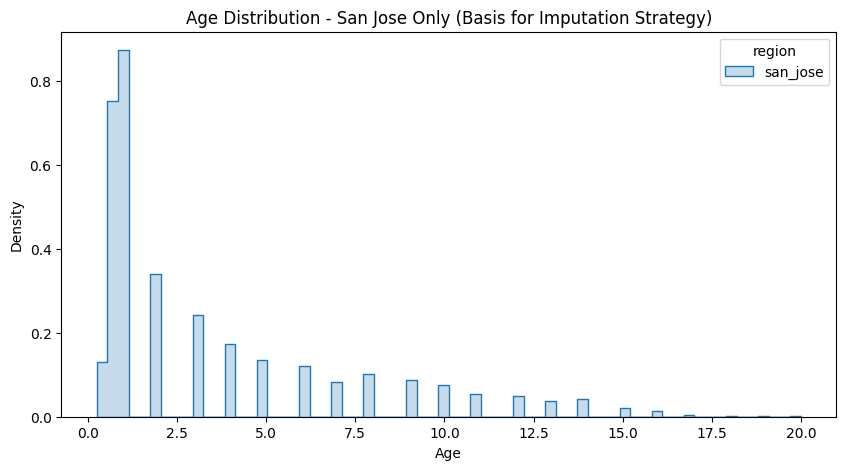

In [443]:
# Visualizing age distribution for available data
# Note: Only san_jose has age data (dallas: 100% missing, soco: 100% missing)
df_age = silver_df[silver_df["age"].notna()]  # Filter to non-null ages only
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_age,
    x="age",
    hue="region",
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Age Distribution - San Jose Only (Basis for Imputation Strategy)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

`Findings:`

- **Heavily right-skewed distribution**: Most animals are very young (0-2 years), with a long tail extending to older ages
- In right-skewed distributions, the mean is pulled higher by outliers, while the median better represents the typical animal age
- Given the clear skewness, we will use **species-specific median imputation** to fill missing age values

>  Imputation strategy: Using the `impute_missing_age()` function, missing ages will be imputed using the median age for each animal type (dog, cat, etc.), ensuring that species-specific age patterns are preserved rather than using a single overall median.

#### 7.1.2 Sex 


The visualization below reveals a critical **data standardization issue** that must be addressed before any meaningful analysis or imputation can occur.

**Key Problem:** Different regions use inconsistent naming conventions for the same biological categories:
- **San Jose**: Uses all caps (MALE, FEMALE, SPAYED, NEUTERED, UNKNOWN)  
- **Soco**: Uses mixed case (Male, Female, Spayed, Neutered, Unknown)
- **Biological Logic**: SPAYED = Female, NEUTERED = Male (spay/neuter procedures are sex-specific)

This creates **fragmentation** where we see 8+ distinct categories instead of the true 2-3 meaningful groups (male, female, unknown).

Without standardization, we cannot:
- Calculate accurate sex distributions by region
- Develop reliable breed-based imputation patterns for Dallas (100% missing sex data)
- Make meaningful comparisons across datasets

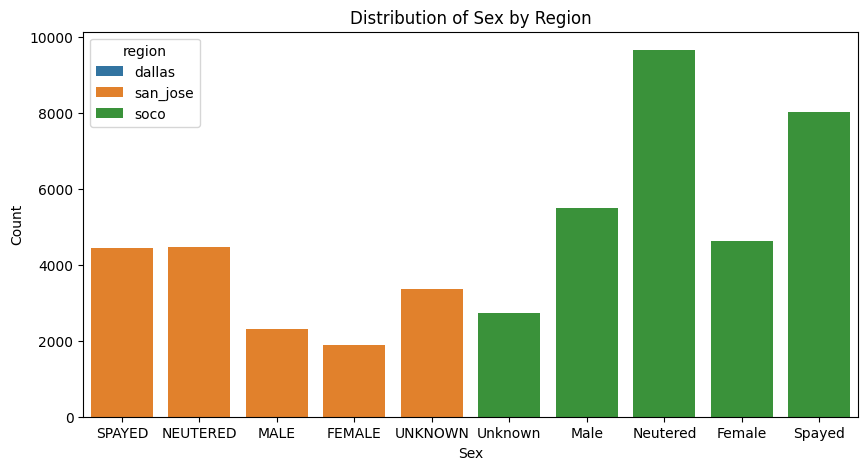

In [444]:
# Visulaizing the sex and the distribution
df_sex = silver_df
plt.figure(figsize=(10, 5))
sns.countplot(data=df_sex, x="sex", hue="region")
plt.title("Distribution of Sex by Region")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

`Findings:`

- As we can see different regions use inconsistent naming conventions for the same biological categories
- Without standardization, we cannot develop reliable breed-based imputation patterns for Dallas (100% missing sex data)

> **Implementation:** with a two-step process using `recategarize_sex()` to first harmonize biological categories (Male group: MALE, Male, NEUTERED, Neutered -> "male"; Female group: FEMALE, Female, SPAYED, Spayed -> "female"), then `impute_sex_by_species_and_breed()` to fill missing values using species-breed probability distributions. This ensures both data consistency and informed imputation based on breed characteristics.

#### 7.1.3 Primary Color

Similar to `sex`, primary color data required significant **consolidation** due to an overwhelming number of highly specific color variants that would make meaningful analysis quite difficult.

**The Problem:** Raw data contained 350+ unique color combinations including:
- Highly specific patterns: "blue_merle", "gray_tabby", "black_tricolor" 
- Single-occurrence colors that provide no statistical power
- Inconsistent terminology across regions

**Key Challenge:** Dallas has **100% missing primary color data** and will require breed-based imputation which will be derived from san_jose and soco patterns.

**Binning Strategy:** Consolidated rare and highly specific colors into broader, meaningful categories, with uncommon variants grouped as "other."

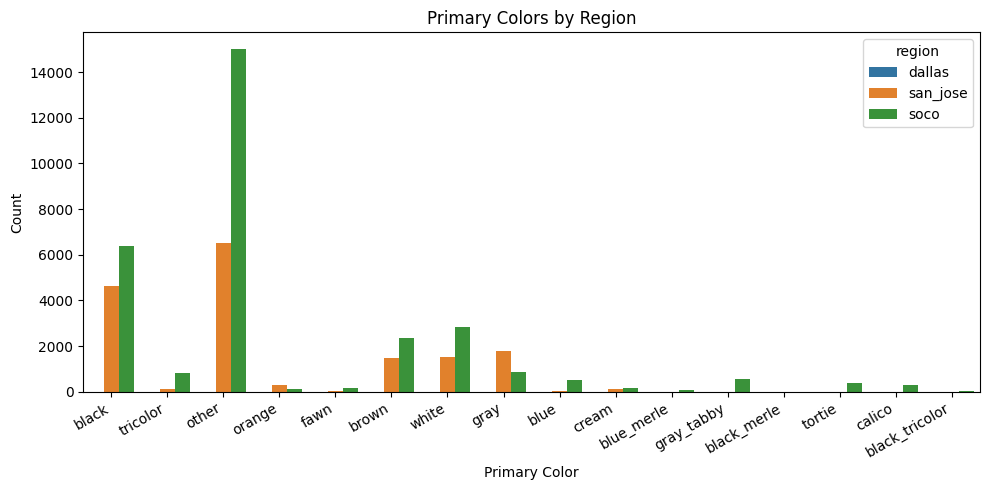

In [445]:
# visualizing color distribution
df_color = silver_df
plt.figure(figsize=(10, 5))
sns.countplot(data=df_color, x="primary_color", hue="region")
plt.title("Primary Colors by Region")
plt.xlabel("Primary Color")
plt.ylabel("Count")

# to make the primary color labels not overlap
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

`Findings:`

1. The high frequency of "other" (especially in soco) demonstrates just how fragmented the original color data was - hundreds of rare color variants have been consolidated into this single category.

2. **Regional Patterns Emerge**: After binning, we can see meaningful differences:
   - **San Jose**: More balanced distribution across black, other, white, gray
   - **Soco**: Heavily skewed toward "other" category, suggesting more diverse/specific color reporting

3. **Dallas Absence**: No blue bars confirm 100% missing primary color data - this cleaned distribution from san_jose and soco will inform our **species-breed probabilistic imputation**.

> Imputation Strategy: Using the `impute_primary_color_by_species_and_breed()` function, missing colors in dallas will be randomly assigned based on the probability distributions observed for each animal_type-breed combination in the available data.

This approach preserves the realistic color diversity while ensuring statistically sound imputation based on biological breed characteristics.

----

## 8. Data Imputation Implementation

Having identified the missing data patterns and developed targeted imputation strategies through EDA, we now implement these solutions to create a complete, analysis-ready dataset to build our Gold tables.

**Data Standardization Through Binning:**

Before imputation could be effective, we addressed severe **cardinality and standardization issues**.

**Imputation Strategy Summary:**
- **Age**: Species-specific medians using `impute_missing_age()` and date calculations via `compute_age_from_dates()`
- **Sex**: Two-step process with `recategarize_sex()` + `impute_sex_by_species_and_breed()`  
- **Primary Color**: Breed-based probabilistic imputation using `impute_primary_color_by_species_and_breed()`

This  approach makes sure that dallas (100% missing demographics) receives imputations based on **standardized patterns** observed in san_jose and soco datasets.



### 8.1 Age Imputation and Validation

**Step 1: Compute Age from Available Dates**

First, we maximize available age data by calculating ages from date_of_birth and intake_date where both are available.

Computed age for 23121 rows


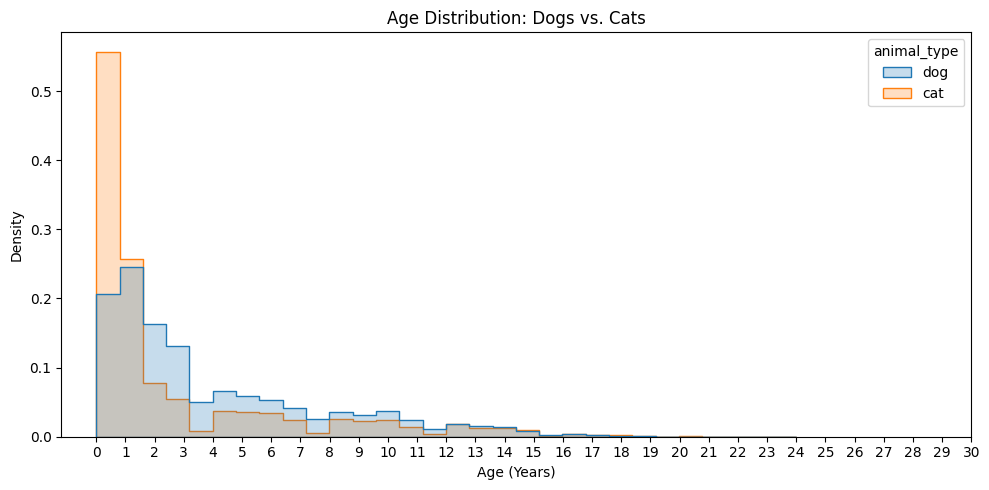

In [446]:
silver_df = compute_age_from_dates(silver_df)

# Filter to valid ages and only dogs and cats
df_age_cal = silver_df.copy()
df_age_cal = df_age_cal[
    df_age_cal["age"].notna()
    & (df_age_cal["age"] >= 0)
    & (df_age_cal["age"] <= 30)
    & (df_age_cal["animal_type"].isin(["dog", "cat"]))
]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_age_cal,
    x="age",
    hue="animal_type",
    element="step",
    stat="density",
    common_norm=False,
    bins=30,
)
plt.title("Age Distribution: Dogs vs. Cats")
plt.xlabel("Age (Years)")
plt.ylabel("Density")
plt.xticks(np.arange(0, 31, 1))
plt.tight_layout()
plt.show()

`Findings`:

- With this function we were able to gain an additional 23,124 data points for `age`
- Both dogs and cats show **right-skewed distributions** with peaks at younger ages
- Cats are especially high in the 0-1 range, suggesting that many kittens are brought into the shelter
- This graph justifies our reasoning for going forward with species-specific median imputation due to the distinct data distributions

> **Next Step**: Apply `impute_missing_age()` to fill remaining missing values across all datasets.

#### 8.2 Apply Species-Specific Median Imputations and Age Binning

Below, we impute missing ages and create a new column which bins ages into meaningful life stage categories for enhanced analysis.

In [447]:
print("> Beginning age imputation...\n")
silver_df = impute_missing_age(silver_df)

# Adding in additional column which buckets the age into life stages
print("-" * 60)
print("> Binning ages into life stages...\n")
silver_df = bin_age_into_life_stages(silver_df)
print("-" * 60)
print("Age imputation and binning complete.")

> Beginning age imputation...

Imputed 46075 missing ages for species: dog (median=2.49)
Imputed 25201 missing ages for species: cat (median=0.88)
Imputed 8260 missing ages for species: other (median=1.00)
------------------------------------------------------------
> Binning ages into life stages...

Binned age into categories: puppy/kitten, adult, senior
------------------------------------------------------------
Age imputation and binning complete.


`Findings:`

- Successfully filled **79,479 missing ages** across all datasets
- Dogs (2.49 years), cats (0.83 years), other animals (1.00 year) - **confirming younger intake patterns for cats**
- All ages also got binned into categories (puppy/kitten, adult, senior) for further insights

> **Next Step**: Apply sex standardization and imputation using `recategarize_sex()` and `impute_sex_by_species_and_breed()`.

#### 8.3 Sex Standardization and Breed-Based Imputation

Apply `recategorize_sex()` to harmonize inconsistent sex labels, then use breed-specific distributions for missing value imputation.

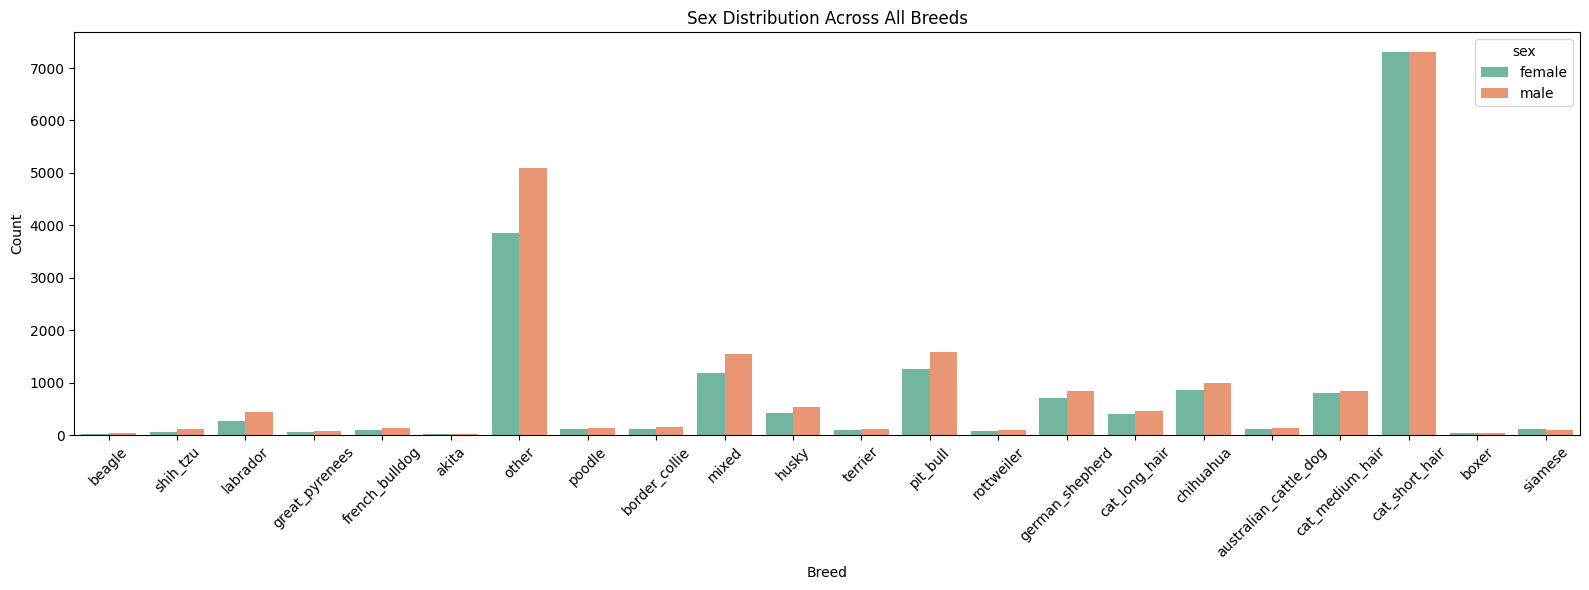

In [448]:
silver_df = recategarize_sex(silver_df)

# Filter to relevant data
df_breed_sex = silver_df.dropna(subset=["sex", "breed"])
df_breed_sex = df_breed_sex[df_breed_sex["animal_type"].isin(["dog", "cat"])]

# Compute proportion female per breed
breed_sex_dist = (
    df_breed_sex.groupby(["breed", "sex"])
    .size()
    .unstack(fill_value=0)
    .assign(total=lambda d: d.sum(axis=1))
    .assign(percent_female=lambda d: 100 * d.get("female", 0) / d["total"])
    .sort_values("percent_female")
    .reset_index()
)

# Get sorted breed list
sorted_breeds = breed_sex_dist["breed"].tolist()

# Filter original dataframe to keep only breeds in the sorted list
df_breed_sex = df_breed_sex[df_breed_sex["breed"].isin(sorted_breeds)]

# Plot
plt.figure(figsize=(16, 6))
sns.countplot(
    data=df_breed_sex, x="breed", hue="sex", order=sorted_breeds, palette="Set2"
)
plt.title("Sex Distribution Across All Breeds")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Findings:`

- Clean male/female categories now allow for a more meaningful breed analysis
- Most breeds show ~50% split with a slight male lean, confirming breed-specific imputation will reflect realistic biological distributions rather than random assignment

> **Ready for Imputation Below**: Consistent patterns validate using `impute_sex_by_species_and_breed()` 

In [449]:
# Apply sex imputation and validate results
print("-" * 40)
print("> Applying breed-based sex imputation...")
silver_df = impute_sex_by_species_and_breed(silver_df)

# Validate imputation success
print(f"Missing sex values after imputation: {silver_df['sex'].isna().sum()}")
print("Sex distribution post-imputation:")
for sex, count in silver_df["sex"].value_counts().items():
    percent = (count / silver_df.shape[0]) * 100
    print(f"{sex}: {count:,} ({percent:.1f}%)")
print("Sex imputation complete.")
print("-" * 40)

----------------------------------------
> Applying breed-based sex imputation...
Missing sex values after imputation: 0
Sex distribution post-imputation:
male: 60,436 (53.9%)
female: 51,651 (46.1%)
Sex imputation complete.
----------------------------------------


#### 8.4 Apply Primary Color Imputation  

Extending our breed-based imputation framework to primary color, we utilize `impute_primary_color_by_species_and_breed()` which mirrors our sex imputation logic: grouping by species-breed pairs, calculating normalized color distributions, and probabilistically assigning colors to missing values. This preserves breed-specific color characteristics.

In [450]:
# Apply primary color imputation using same breed-based methodology
print("-" * 60)
print("> Applying breed-based primary color imputation...")
silver_df = impute_primary_color_by_species_and_breed(silver_df)

# Validate completion of all demographic imputations
print("All demographic imputations complete:")
print(f"Missing ages: {silver_df['age'].isna().sum()}")
print(f"Missing sex: {silver_df['sex'].isna().sum()}")
print(f"Missing primary colors: {silver_df['primary_color'].isna().sum()}")
print("-" * 60)

------------------------------------------------------------
> Applying breed-based primary color imputation...
All demographic imputations complete:
Missing ages: 0
Missing sex: 0
Missing primary colors: 0
------------------------------------------------------------


#### 8.5 Imputation Completion Summary

All demographic imputation strategies have been successfully implemented across the consolidated dataset:


In [451]:
print("=== IMPUTATION COMPLETION STATUS ===")
missing_summary = {
    "age": silver_df["age"].isna().sum(),
    "sex": silver_df["sex"].isna().sum(),
    "primary_color": silver_df["primary_color"].isna().sum(),
}

for feature, missing_count in missing_summary.items():
    print(f"{feature.title()}: {missing_count} missing values")

print(f"\nTotal records: {len(silver_df):,}")
print("Dataset ready for analysis and materialization.")

=== IMPUTATION COMPLETION STATUS ===
Age: 0 missing values
Sex: 0 missing values
Primary_Color: 0 missing values

Total records: 112,087
Dataset ready for analysis and materialization.


-----

## 9. Materialize Silver

**Purpose:** Materialize the final Silver data, with all the cleaning done above.

This allows us to build Gold on top of this cleaned data, without having to re-process the data every time. This makes the work more efficient, and follows best practices. 

All ad-hoc analytics, data exploration, analysis, etc. should be done on top of this data, as it is validated and consistent. This sets a strong foundation for the rest of the data work for our team.

Since we do not have a Database, as is common when using Medallion architecture, we are materializing the data by writing it to `.parquet`. Parquet allows for faster analysis, preserves data types for data, and is an efficient standard for data-storage.

### Final Filtering

Before materialization, we are doing a final column-level filter, to only include data we care about for our analysis. This way, downstream work does not use columns that might have been useful for calculations but aren't useful going forwards.

We are:
* removing `date_of_birth` as it was used to calculate age
* selecting exclusively `dog` and `cat` values for `animal_type`
* dropping records with missing `intake_date` (1 row)

In [452]:
# Drop the `date_of_birth` column as it is not needed after age calculation
if "date_of_birth" in silver_df.columns:
    silver_df = silver_df.drop(columns=["date_of_birth"])
# Filter `animal_type` to only include dogs and cats
silver_df = silver_df[silver_df["animal_type"].isin(["dog", "cat"])]
# Drop record with missing `intake_date`
silver_df = silver_df[silver_df["intake_date"].notna()]

silver_df.head()

,animal_id,animal_type,breed,primary_color,age,sex,intake_type,intake_condition,intake_reason,intake_date,outcome_type,outcome_date,region,age_stage
0,A0011910,dog,pit_bull,brown,2.494182,male,stray,healthy,other,2023-12-21,transfer,2024-01-09,dallas,adult
1,A0011910,dog,pit_bull,white,2.494182,female,treatment,healthy,medical,2024-02-19,treatment,2024-02-19,dallas,adult
2,A0178985,dog,rottweiler,other,2.494182,female,stray,medical,other,2024-06-20,euthanasia,2024-06-21,dallas,adult
3,A0180810,dog,mixed,other,2.494182,female,surrender,healthy,owner_surrender,2024-10-07,foster,2024-10-18,dallas,adult
4,A0180810,dog,mixed,black,2.494182,male,foster,healthy,for_adoption,2024-11-13,adoption,2024-11-13,dallas,adult


In [453]:
SILVER_DF_PATH = "../../data-assets/silver/silver.parquet"
os.makedirs(os.path.dirname(SILVER_DF_PATH), exist_ok=True)

silver_df.to_parquet(SILVER_DF_PATH, index=False)
print(f"Saved silver df to {SILVER_DF_PATH}")

Saved silver df to ../../data-assets/silver/silver.parquet


----

## 10. Data Quality Assessment

Comprehensive quality checks and data profiling.

In [454]:
# Lets generate the data profile for the silver dataset
generate_data_overview(silver_df)

DATA QUALITY PROFILE

DATASET OVERVIEW
 Records: 103,037 | Columns: 14

MISSING DATA ANALYSIS
  outcome_date: 2,073 (2.0119%)

CARDINALITY ANALYSIS
  animal_id: 82,747 unique
  intake_date: 3,958 unique
  age: 3,895 unique
  outcome_date: 3,552 unique
  breed: 22 unique
  primary_color: 16 unique
  outcome_type: 15 unique
  intake_type: 12 unique
  intake_reason: 12 unique
  intake_condition: 8 unique
  age_stage: 4 unique
  region: 3 unique
  animal_type: 2 unique
  sex: 2 unique

INTAKE_TYPE DISTRIBUTION
  stray: 62.4%
  surrender: 12.7%
  foster: 12.3%
  confiscated: 4.2%
  treatment: 3.3%
  disposal_request: 1.6%
  protective_custody: 1.4%
  spay_neuter: 1.0%
  transfer: 0.7%
  return_to_owner: 0.2%

ANIMAL_TYPE DISTRIBUTION
  dog: 61.9%
  cat: 38.1%

BREED DISTRIBUTION
  cat_short_hair: 32.7%
  mixed: 31.2%
  other: 12.2%
  pit_bull: 5.7%
  german_shepherd: 3.3%
  cat_medium_hair: 3.1%
  chihuahua: 2.8%
  husky: 1.8%
  labrador: 1.6%
  cat_long_hair: 1.4%

PRIMARY_COLOR DISTRIBUTI

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_69392/3372730966.py:218: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("intake_date").resample("M").size()


-----

## 11. References  
Databricks. (n.d.). *Medallion Architecture*. Retrieved May 10, 2025, from https://www.databricks.com/glossary/medallion-architecture